# Research Problem

Last year, I read a paper titled, "Feature Selection Methods for Identifying Genetic Determinants of Host Species in RNA Viruses". This year, I read another paper titled, "Predicting host tropism of influenza A virus proteins using random forest". The essence of these papers were to predict influenza virus host tropism from sequence features. The particular feature engineering steps were somewhat distinct, in which the former used amino acid sequences encoded as binary 1/0s, while the latter used physiochemical characteristics of the amino acid sequences instead. However, the core problem was essentially identical - predict a host classification from influenza protein sequence features. Random forest classifiers were used in both papers, and is a powerful method for identifying non-linear mappings from features to class labels. My question here was to see if I could get comparable performance using a simple neural network.

# Data

I downloaded influenza HA sequences from the Influenza Research Database. Sequences dated from 1980 to 2015. Lab strains were excluded, duplicates allowed (captures host tropism of certain sequences). All viral subtypes were included.

Below, let's take a deep dive into what it takes to construct an artificial neural network!

The imports necessary for running this notebook.

In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from collections import Counter
from sklearn.preprocessing import LabelBinarizer
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import mutual_info_score as mi

Read in the viral sequences.

In [2]:
sequences = SeqIO.to_dict(SeqIO.parse('20150902_nnet_ha.fasta', 'fasta'))
sequences

{'CY092289|Human': SeqRecord(seq=Seq('MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTITNDQIEVTN...ICI', SingleLetterAlphabet()), id='CY092289|Human', name='CY092289|Human', description='CY092289|Human', dbxrefs=[]),
 'CY045191|Human': SeqRecord(seq=Seq('MEAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTHSVNLLEDKH...ICI', SingleLetterAlphabet()), id='CY045191|Human', name='CY045191|Human', description='CY045191|Human', dbxrefs=[]),
 'KF761464|Human': SeqRecord(seq=Seq('MKAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTHSVNLLEDKH...ICI', SingleLetterAlphabet()), id='KF761464|Human', name='KF761464|Human', description='KF761464|Human', dbxrefs=[]),
 'CY138528|American_Black_Duck': SeqRecord(seq=Seq('MEAKLFVLFCTFTVLKADTICVGYHANNSTDTVDTVLEKNVTVTHSVNLLEDSH...ICI', SingleLetterAlphabet()), id='CY138528|American_Black_Duck', name='CY138528|American_Black_Duck', description='CY138528|American_Black_Duck', dbxrefs=[]),
 'CY051439|Human': SeqRecord(seq=Seq('MKAILVVLLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHSVNLLEDKH

The sequences are going to be of variable length. To avoid the problem of doing multiple sequence alignments, filter to just the most common length (i.e. 566 amino acids).

In [3]:
lengths = Counter()
for accession, seqrecord in sequences.items():
    lengths[len(seqrecord.seq)] += 1
    
lengths.most_common(1)[0][0]

566

In [4]:
# For convenience, we will only work with amino acid sequencees of length 566.
final_sequences = dict()
for accession, seqrecord in sequences.items():
    if len(seqrecord.seq) == lengths.most_common(1)[0][0]:
        final_sequences[accession] = seqrecord

Create a `numpy` array to store the alignment.

In [5]:
alignment = MultipleSeqAlignment(final_sequences.values())
alignment = np.array([list(rec) for rec in alignment], np.character)

The first piece of meat in the code begins here. In the cell below, we convert the sequence matrix into a series of binary `1`s and `0`s, to encode the features as numbers. This is important - AFAIK, almost all machine learning algorithms require numerical inputs.

In [6]:
# Create an empty dataframe.
df = pd.DataFrame()

# Create a dictionary of position + label binarizer objects.
pos_lb = dict()

for pos in range(lengths.most_common(1)[0][0]):
    # Convert position 0 by binarization.
    lb = LabelBinarizer()
    # Fit to the alignment at that position.
    lb.fit(alignment[:,pos])
    # Add the label binarizer to the dictionary.
    pos_lb[pos] = lb
    # Create a dataframe.
    pos = pd.DataFrame(lb.transform(alignment[:,pos]))

    # Append the columns to the dataframe.
    for col in pos.columns:
        maxcol = len(df.columns)
        df[maxcol + 1] = pos[col]
    
df

,1,2,3,4,5,6,7,8,9,10,...,6741,6742,6743,6744,6745,6746,6747,6748,6749,6750
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


With the cell above, we now have a sequence feature matrix, in which the 566 amino acids positions have been expanded to 6750 columns of binary sequence features.

The next step is to grab out the host species labels, and encode them as 1s and 0s as well.

In [13]:
# Grab out the labels.
host_species = [s.id.split('|')[1] for s in final_sequences.values()]
host_species

output_lb = LabelBinarizer()
output_lb.fit(host_species)
Y = output_lb.transform(host_species)
X = df.values
X.shape

(28226, 6750)

In [23]:
X = X.astype(np.float32)  # Necessary for passing the data into nolearn.
X.shape

(28226, 6750)

In [25]:
Y = Y.astype(np.float32)  # Necessary for passing the data into nolearn.
Y.shape

(28226, 104)

Next up, we do the train/test split.

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

For comparison, let's train a random forest classifier, and see what the concordance is between the predicted labels and the actual labels.

In [27]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
predictions = rf.predict(X_test)
predicted_labels = output_lb.inverse_transform(predictions)
# Compute the mutual information between the predicted labels and the actual labels.
mi(predicted_labels, output_lb.inverse_transform(Y_test))

0.86997584269837236

By the majority-consensus rule, and using mutual information as the metric for scoring, things look not so bad! As mentioned above, the `RandomForestClassifier` is a pretty powerful method for finding non-linear patterns between features and class labels.

Uncomment the cell below if you want to try the `scikit-learn`'s `ExtraTreesClassifier`.

In [28]:
# et = ExtraTreesClassifier()
# et.fit(X_train, Y_train)
# predictions = et.predict(X_test)
# predicted_labels = output_lb.inverse_transform(predictions)
# mi(predicted_labels, output_lb.inverse_transform(Y_test))

Alrighty - we're now ready to try out a neural network! For this try, we will use `lasagne` and `nolearn`, two packages which have made things pretty easy for building neural networks. In this segment, I'm going to not show experiments with multiple architectures, activations and the like. The goal is to illustrate how easy the specification of a neural network is.

First off, these are the import statements necessary for constructing and testing a neural network.

In [29]:
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
import theano
theano.config.blas.ldflags = '' # optional. Blas was giving me an error.

The network architecture that we'll try is as such:

- 1 input layer, of shape 6750 (i.e. taking in the columns as data).
- 1 hidden layer, with 300 units.
- 1 output layer, of shape 140 (i.e. each of the class labels).

In [100]:
net1 = NeuralNet(layers=[
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
    ],
        # Layer parameters:
        input_shape=(None, X.shape[1]),
        hidden_num_units=300,
        output_nonlinearity=None,
        output_num_units=Y.shape[1],
        #allow_input_downcast=True,

        # Optimization Method:
        update=nesterov_momentum,
        update_learning_rate=0.01,
        update_momentum=0.9,
                
        regression=True,
        max_epochs=100,
        verbose=1
        )

Training a simple neural network on my MacBook Air takes quite a bit of time :). But the function call for fitting it is a simple `nnet.fit(X, Y)`.

In [101]:
net1.fit(X_train, Y_train)

# Neural Network with 2056604 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input     6750
  1  hidden     300
  2  output     104

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.01034       0.00516      2.00302  8.49s
      2       0.00459       0.00424      1.08266  8.31s
      3       0.00395       0.00379      1.04359  9.83s
      4       0.00360       0.00350      1.02658  8.18s
      5       0.00336       0.00330      1.01765  8.16s
      6       0.00319       0.00315      1.01237  9.95s
      7       0.00305       0.00303      1.00862  10.22s
      8       0.00294       0.00292      1.00566  9.48s
      9       0.00284       0.00283      1.00351  10.40s
     10       0.00276       0.00276      1.00202  9.86s
     11       0.00269       0.00269      1.00067  11.54s
     12       0.00262       0.00262      0.99938  8.96s
     13       0.00256       0.00257     

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x11af796a0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x11af79630>,
     custom_score=None, hidden_num_units=300, input_shape=(None, 6750),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=100, more_params={},
     objective=<function objective at 0x11af781e0>,
     objective_loss_function=<function squared_error at 0x11ad8ea60>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog object at 0x20cad3ba8>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo object at 0x20cad3208>],
     output_nonlinearity=None, output_num_units=104, regression=True,
     train_split=<nolearn.lasagne.base.TrainSplit object at 0x11af796d8>,
     update=<function nestero

Let's grab out the predictions!

In [102]:
preds = net1.predict(X_test)
preds.shape

(7057, 104)

We're going to see how good the classifier did by examining the class labels. The way to visualize this is to have, say, the class labels on the X-axis, and the probability of prediction on the Y-axis. We can do this sample by sample. Here's a simple example with no frills in the matplotlib interface.

<Container object of 104 artists>

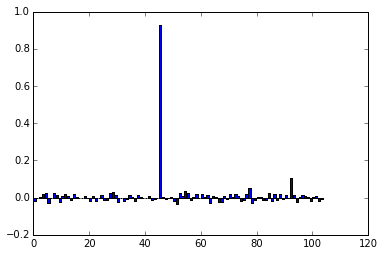

In [103]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.bar(np.arange(len(preds[0])), preds[0])

Alrighty, let's add some frills - the class labels, the probability of each class label, and the original class label.

At the same time, let's take a look at some of the unidentified samples - the ones marked `Environment`. What might they have come from?

In [134]:
test_labels = output_lb.inverse_transform(Y_test)
pos_where_environment = []
for i, label in enumerate(test_labels):
    # if label not in ['Human', 'Duck', 'Swine', 'Northern_Pintail', 'Mallard']:
    if label == 'Environment':
        pos_where_environment.append(i)
        
pos_where_environment[-500:]

[757,
 816,
 1075,
 1125,
 1334,
 1984,
 2045,
 2505,
 3119,
 3188,
 3299,
 3355,
 4045,
 4608,
 5127,
 5134,
 5669,
 5942,
 6289,
 6965,
 7033]

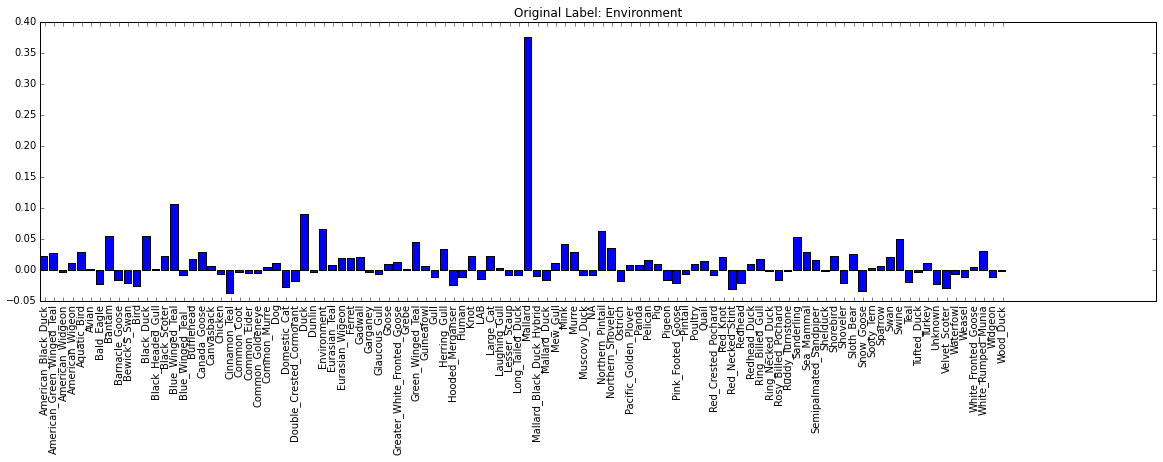

In [136]:
### NOTE: Change the value of i to anything above!

#i = 3725 # this one showed an interesting pattern!
#i = 1 # also showed interesting pattern!
i = 5942
# plt.bar(np.arange(len(preds[i])), preds[i])
plt.figure(figsize=(20,5))
plt.bar(np.arange(len(output_lb.classes_)), preds[i])
plt.xticks(np.arange(len(output_lb.classes_)) + 0.5, output_lb.classes_, rotation='vertical')
plt.title('Original Label: ' + output_lb.inverse_transform(Y_test)[i])
plt.show()
# print(output_lb.inverse_transform(Y_test)[i])

Let's do a majority-consensus rule applied to the labels, and then compute the mutual information score again.

In [139]:
preds_labels = []
for i in range(preds.shape[0]):
    maxval = max(preds[i])
    pos = list(preds[i]).index(maxval)
    
    preds_labels.append(output_lb.classes_[pos])

mi(preds_labels, output_lb.inverse_transform(Y_test))

0.72669604801694099

With a score of 0.73, that's not bad either! It certainly didn't outperform the `RandomForestClassifier`, but the default parameters on the RFC were probably pretty good to begin with. Notice how little tweaking on the neural network we had to do as well.

For good measure, these were the class labels. Notice how successful influenza has been in replicating across the many different species!

In [73]:
output_lb.classes_

array(['American_Black_Duck', 'American_Green_Winged_Teal',
       'American_Widgeon', 'American_Wigeon', 'Aquatic_Bird', 'Avian',
       'Bald_Eagle', 'Bantam', 'Barnacle_Goose', "Bewick'S_Swan", 'Bird',
       'Black_Duck', 'Black_Headed_Gull', 'Black_Scoter',
       'Blue_Winged_Teal', 'Blue_Winged_Teal_', 'Bufflehead',
       'Canada_Goose', 'Canvasback', 'Chicken', 'Cinnamon_Teal',
       'Common_Coot', 'Common_Eider', 'Common_Goldeneye', 'Common_Murre',
       'Dog', 'Domestic_Cat', 'Double_Crested_Cormorant', 'Duck', 'Dunlin',
       'Environment', 'Eurasian_Teal', 'Eurasian_Wigeon', 'Ferret',
       'Gadwall', 'Garganey', 'Glaucous_Gull', 'Goose',
       'Greater_White_Fronted_Goose', 'Grebe', 'Green_Winged_Teal',
       'Guineafowl', 'Gull', 'Herring_Gull', 'Hooded_Merganser', 'Human',
       'Knot', 'LAB', 'Large_Cat', 'Laughing_Gull', 'Lesser_Scaup',
       'Long_Tailed_Duck', 'Mallard', 'Mallard_Black_Duck_Hybrid',
       'Mallard_Duck', 'Mew_Gull', 'Mink', 'Murre', 'Muscov

# The biology behind this dataset.

A bit more about the biology of influenza.

If you made it this far, thank you for hanging on! How does this mini project relate to the biology of flu? 

As the flu evolves and moves between viral hosts, it gradually adapts to that host. This allows it to successfully establish an infection in the host population. 

We can observe the viral host as we sample viruses from it. Sometimes, we don't catch it in its adapted state, but it's un-adapted state, as if it had freshly joined in from its other population. That is likely why some of the class labels are mis-identified.

Also, there are environmentally sampled isolates. They obviously aren't simply replicating in the environment (i.e. bodies of water), but in some host, and were shed into the water. For these guys, the host labels won't necessarily match up, as there'll be a stronger signal with particular hosts - whether it be from ducks, pigs or even humans.

# Next steps?

There's a few obvious things that can be done. 

1. Latin hypercube sampling for Random Forest parameters.
2. Experimenting with adding more layers, tweaking the layer types etc.

What else might be done? Ping me at ericmajinglong@gmail.com with the subject "neural nets and HA". :)